# Imports

In [1]:
import sys

sys.path.append("..")
import pickle as pkl
from dataclasses import asdict, is_dataclass

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
from dacite import from_dict
from ipywidgets import interact

from calibration.benchmark.benchmark import BenchmarkResult
from calibration.feature_detector.visualization import show_boards, show_corners
from calibration.projector.board import gen_checkerboard_grid
from calibration.projector.camera import Camera

# pio.renderers.default = "svg"
from calibration.projector.projector import Projector
from calibration.solver.solve import solve

%load_ext autoreload
%autoreload 2

In [2]:
with open("../babelcalib_results.pkl", "rb") as f:
    results = pkl.load(f)

In [3]:
df = pd.json_normalize(
    [{k: v for k, v in asdict(r).items() if v is not None} for r in results]
)

# EDA

In [4]:
# df.describe(include="all")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   error                           792 non-null    float64
 1   input.ds_name                   792 non-null    object 
 2   input.subds_name                792 non-null    object 
 3   input.name                      792 non-null    object 
 4   input.width                     792 non-null    int64  
 5   input.height                    792 non-null    int64  
 6   input.num_corners               792 non-null    int64  
 7   input.encoding                  792 non-null    object 
 8   input.corners                   792 non-null    object 
 9   input.image                     792 non-null    object 
 10  features.board                  792 non-null    object 
 11  features.corners                792 non-null    object 
 12  prediction.R                    792 

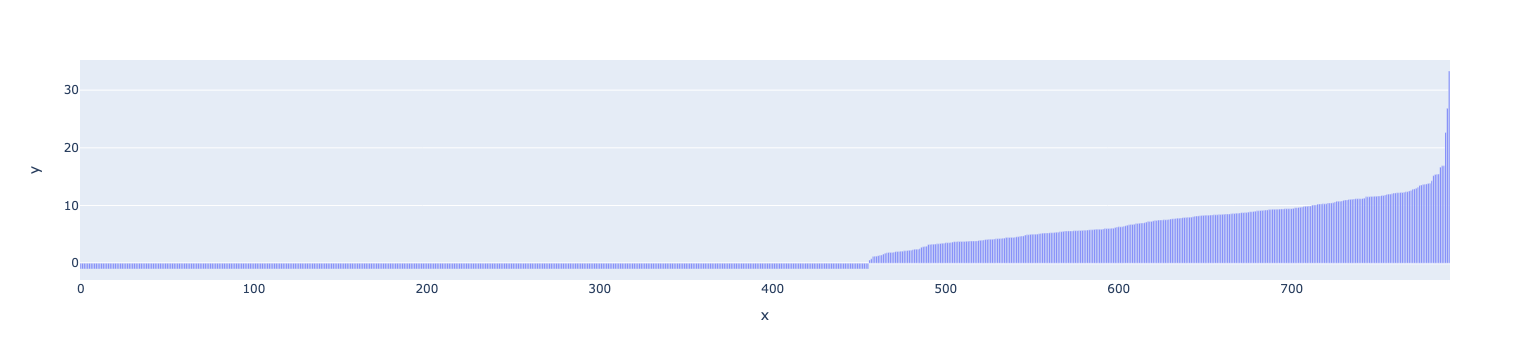

In [5]:
results_ = sorted([r for r in results if r.error is not None], key=lambda r: r.error)
df_ = df[~df["error"].isna()].sort_values("error")

px.bar(y=sorted([r.error for r in results_]))

In [6]:
# filtered_df = df.groupby('input.ds_name').filter(lambda x: all(x['error'].isin([None, -1])))
filtered_df = df.groupby("input.ds_name").filter(lambda x: all(x["error"].isna()))

# Get the unique dataset names
dataset_names1 = filtered_df["input.ds_name"].unique()
dataset_names1

array([], dtype=object)

In [7]:
# filtered_df = df.groupby('input.ds_name').filter(lambda x: all(x['error'].isin([None, -1])))
filtered_df = df.groupby("input.ds_name").filter(lambda x: all(x["error"] == -1))

# Get the unique dataset names
dataset_names2 = filtered_df["input.ds_name"].unique()
dataset_names2

array(['OCamCalib/Fisheye190deg', 'OCamCalib/MiniOmni',
       'OCamCalib/KaidanOmni'], dtype=object)

In [8]:
set(df["input.ds_name"].unique()) - set(dataset_names1) - set(dataset_names2)

{'OCamCalib/Fisheye1',
 'OCamCalib/Fisheye2',
 'OCamCalib/GOPR',
 'OCamCalib/Ladybug',
 'OCamCalib/VMRImage',
 'OV/corner/ov00',
 'OV/corner/ov01',
 'OV/corner/ov02',
 'OV/corner/ov03',
 'OV/corner/ov04',
 'OV/corner/ov05',
 'OV/corner/ov06',
 'OV/corner/ov07',
 'OV/cube/ov00',
 'OV/cube/ov01',
 'OV/cube/ov02',
 'OV/cube/ov03',
 'OV/single_plane/130108MP',
 'OV/single_plane/2012-A0',
 'OV/single_plane/3136-H0',
 'OV/single_plane/5501-C4'}

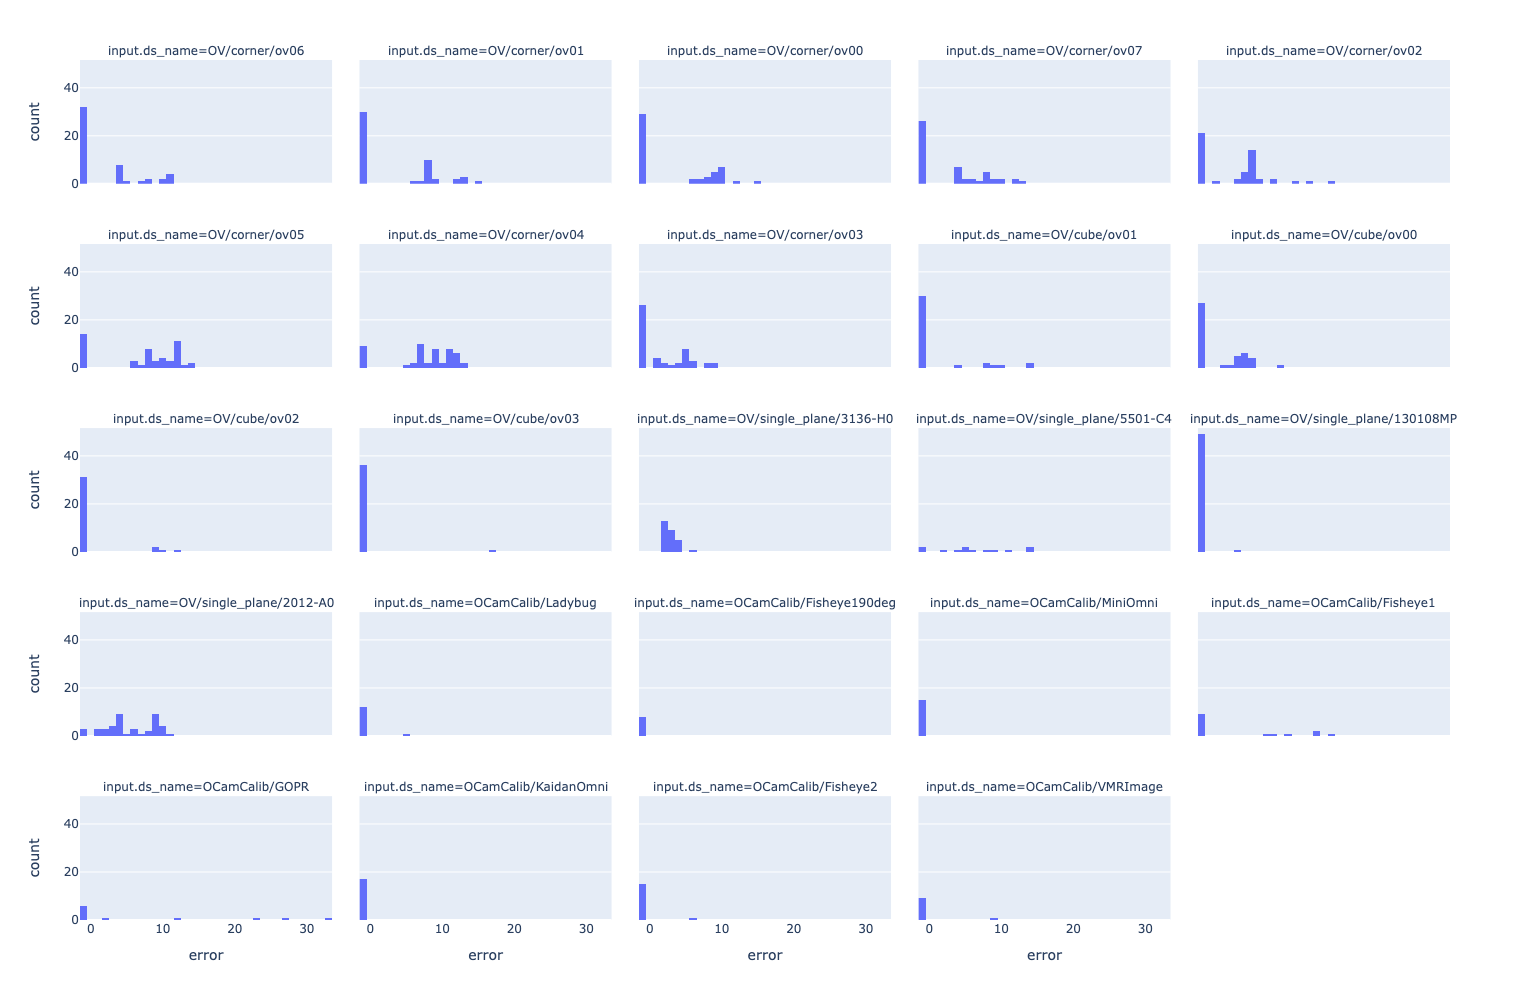

In [9]:
px.histogram(df, x="error", facet_col="input.ds_name", facet_col_wrap=5, height=1000)

In [10]:
@interact
def f(i=(0, len(results_))):
    r = results_[i]
    w, h = r.input.image.size

    if r.features is None:
        print("No features")
    else:
        fig1 = show_boards(
            r.input.image, r.features.corners, r.features.board
        ).update_layout(title=f"{i}, error={r.error}", height=h, width=w)
        display(fig1)
        display(
            px.scatter(
                r.features.board,
                x=0,
                y=1,
                color=range(r.features.board.shape[0]),
                title="Original board",
                # height=h,
                # width=w,
            )
        )
        display(
            px.scatter(
                r.features.corners,
                x=0,
                y=1,
                title="Original corners",
                color=range(r.features.corners.shape[0]),
                range_x=[0, w],
                range_y=[0, h],
                # height=h,
                # width=w,
            ).update_yaxes(autorange="reversed")
        )

        board_ = r.prediction.backproject(r.features.corners)
        display(
            px.scatter(
                board_,
                x=0,
                y=1,
                title="Backprojected board",
                # height=h,
                # width=w,
            )
        )
        try:
            max_point_img_space = np.r_[r.prediction.camera.resolution, 1]
            max_point = (
                np.linalg.inv(r.prediction.camera.intrinsic_matrix)
                @ max_point_img_space
            )
            max_r = float(np.linalg.norm(max_point[:2]))
            corners_ = r.prediction.project(r.features.board, max_r * 10)
            # corners_ = r.prediction.project(r.features.board, 100)
            display(
                px.scatter(
                    corners_,
                    x=0,
                    y=1,
                    title="Projected corners",
                    range_x=[0, w],
                    range_y=[0, h],
                    # height=h,
                    # width=w,
                ).update_yaxes(autorange="reversed")
            )
        except ValueError:
            print("Cannot project")

        print(r.prediction.R)
        print(r.prediction.t)
        print(r.prediction.lambdas)

interactive(children=(IntSlider(value=396, description='i', max=792), Output()), _dom_classes=('widget-interac…

# 585

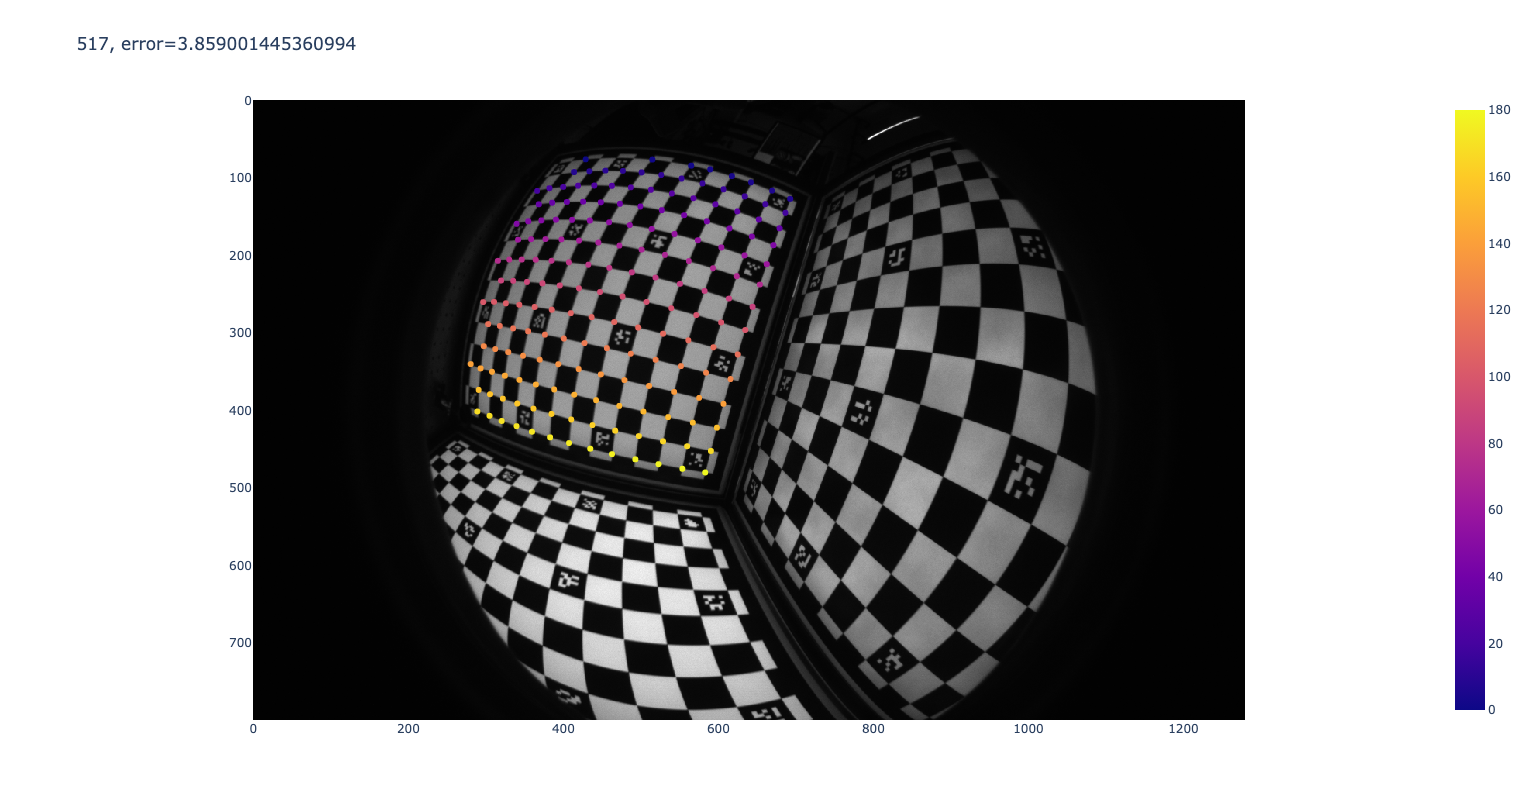

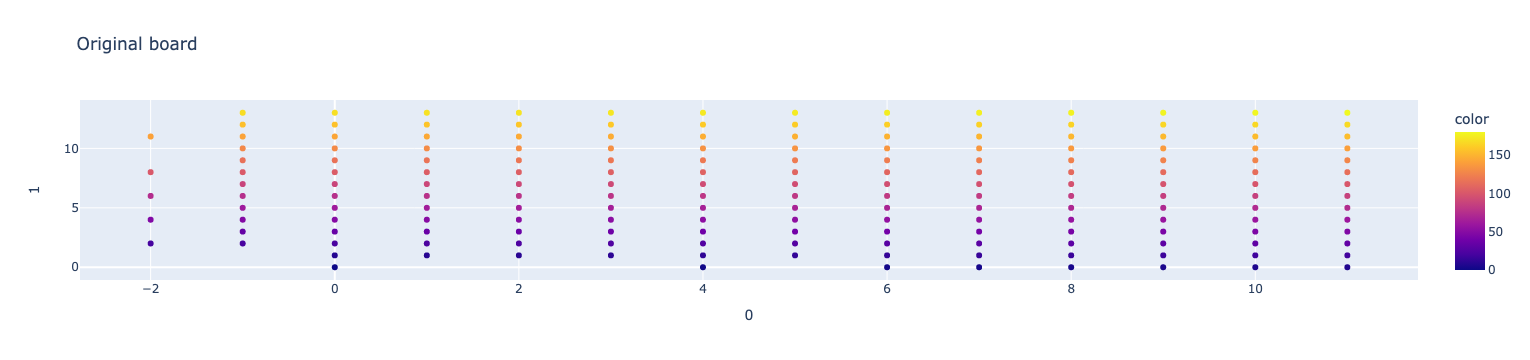

In [17]:
i = 517

r = results_[i]
w, h = r.input.image.size

fig1 = show_boards(r.input.image, r.features.corners, r.features.board).update_layout(
    title=f"{i}, error={r.error}", height=h, width=w
)
display(fig1)
display(
    px.scatter(
        r.features.board,
        x=0,
        y=1,
        color=range(r.features.board.shape[0]),
        title="Original board",
        # height=h,
        # width=w,
    )
)

In [19]:
r.input.ds_name, r.input.subds_name, r.input.name

('OV/cube/ov00', 'train', 'ov00/0031.pgm')

In [12]:
resolution = np.array(r.input.image.size)
sensor_size = np.array([36, 36.0 * resolution[1] / resolution[0]])
focal_length = 35
camera = Camera(
    focal_length=focal_length, resolution=resolution, sensor_size=sensor_size
)

In [13]:
X = r.features.board
x = r.features.corners

proj = solve(x, X, camera)

In [14]:
proj

Projector(R=array([[ 0.18203915,  0.72488472, -0.66438233],
       [-0.68102411,  0.58032546,  0.4465742 ],
       [ 0.7092728 ,  0.3711664 ,  0.59930593]]), t=array([-7.65617314,  2.15311027,  5.32588531]), lambdas=array([-25.59875222, 203.15023208]), camera=Camera(focal_length=35, sensor_size=array([36., 27.]), resolution=array([640, 480]), skew=0.0))

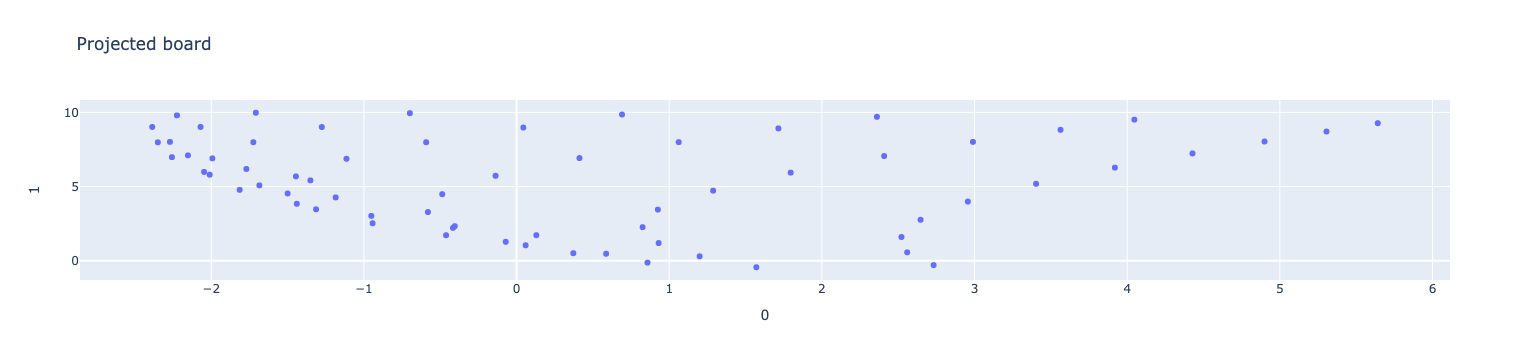

In [15]:
X_ = proj.backproject(x)
display(
    px.scatter(
        X_,
        x=0,
        y=1,
        title="Projected board",
        # range_x=[0, w],
        # range_y=[0, h],
        # height=h,
        # width=w,
    )
)

In [16]:
x_ = proj.project(X, 100000)
display(
    px.scatter(
        x_,
        x=0,
        y=1,
        title="Projected corners",
        range_x=[0, w],
        range_y=[0, h],
        # height=h,
        # width=w,
    ).update_yaxes(autorange="reversed")
)

ValueError: f(a) and f(b) must have different signs